<a href="https://colab.research.google.com/github/rwydaeghe/smartwindows/blob/master/Poisson_equation_using_Fenics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Configure Fenics on google colab

In [0]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2019.1.0


In [0]:
from dolfin import *
import matplotlib.pyplot as plt
import time

In [0]:
t = time.clock()

# Classes for different electrodes
class E1(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 0.0) and between(x[0], (0.0,4.0e-5)))

class E2(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 0.0) and between(x[0], (8.0e-5,12.0e-5))) 

class E3(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 5.0e-5) and between(x[0], (4.0e-5,8.0e-5)))

class E4(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 5.0e-5) and between(x[0], (12.0e-5,16.0e-5)))

# Initialize sub-domain instances
e1 = E1()
e2 = E2()
e3 = E3()
e4 = E4()
  


In [0]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary to left boundary 
    def map(self, x, y):
        y[0] = x[0] - 16.0e-5
        y[1] = x[1]

# Create periodic boundary condition
pbc = PeriodicBoundary()

In [0]:
# Create mesh and finite element
p0 = Point(0.0,0)
p1 = Point(16.0e-5,5.0e-5)
mesh = RectangleMesh(p0,p1,1600,500)
V = FunctionSpace(mesh, "CG", 1, constrained_domain=pbc)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)


In [0]:
# Define Dirichlet boundary conditions for the four electrodes
bcs = [DirichletBC(V, 1.0e-5, e1), DirichletBC(V, 1.0e-5, e2), DirichletBC(V, 1.0e-5, e3), DirichletBC(V, 1.0e-5, e4),]

In [0]:
a = dot(grad(u), grad(v))*dx
L = f*v*dx

In [0]:
# Compute solution
u = Function(V)
solve(a == L, u, bcs)
print(time.clock()-t)

37.27913


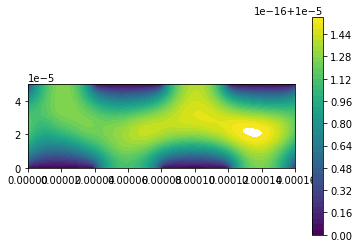

In [0]:
# Plot solution
c = plot(u)
plt.colorbar(c)

In [0]:
#mesh = u.function_space().mesh()
#w = u.compute_vertex_values(mesh)
#x = mesh.coordinates()[:,0]
#y = mesh.coordinates()[:,1]
#t = mesh.cells()
